#MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print(mnist.keys())

/opt/homebrew/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [5]:
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
print(X.shape, y.shape)

#총 70000개의 데이터
#각각의 데이터는 28*28 크기의 이미지

(70000, 784) (70000,)


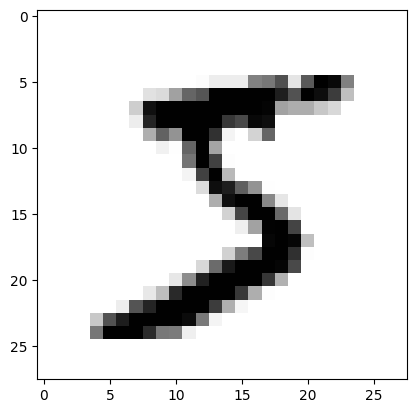

5

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.show()

y[0]

#SGDClassifier
이진 분류기

In [7]:
train_size, test_size = 60000, 10000
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

In [10]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정

### 교차 검증

In [12]:
from sklearn.model_selection import cross_val_score

In [13]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.95035, 0.96035, 0.9604 ])

In [14]:
#무조건 false 반환하는 모델

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

#무조건 5가아님으로 분류하면 평균적으로 90%의 확률이다
#불균형한 데이터셋에서 '정확도'를 성능 측정 지표로 선호하지 않는 이유

array([0.91125, 0.90855, 0.90915])

### 오차 행렬

In [16]:
from sklearn.model_selection import cross_val_predict

In [17]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
confusion_matrix(y_train_5, y_train_pred)
#행은 실제 클래스
#열은 예측한 클래스

array([[53892,   687],
       [ 1891,  3530]])

In [20]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)
#완벽한 분류기

array([[54579,     0],
       [    0,  5421]])

정밀도 = TP/(TP+FP)  
재현율 = TP/(TP+FN)

In [21]:
from sklearn.metrics import precision_score, recall_score

In [22]:
pscore = precision_score(y_train_5, y_train_pred)
rscore = recall_score(y_train_5, y_train_pred)
print(pscore, rscore)

0.8370879772350012 0.6511713705958311


F1 score = 2/(1/정밀도 + 1/재현율)  
정밀도와 재현율이 비슷할 떄 F1 score 높음

In [23]:
from sklearn.metrics import f1_score

In [24]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 정밀도/재현율 트레이드오프
SGDClassifier는 결정함수를 사용하여 각 샘플의 점수를 계산    
샘플의 점수가 결정 임곗값보다 낮으면 음성, 높으면 양성

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [27]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

threshold가 0일 때는 양성으로 분류했지만, threshold가 8000이 되면 음성으로 분류한다.     
정밀도와 재현율 사이의 tradeoff가 존재!

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function", n_jobs=-1)

In [29]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

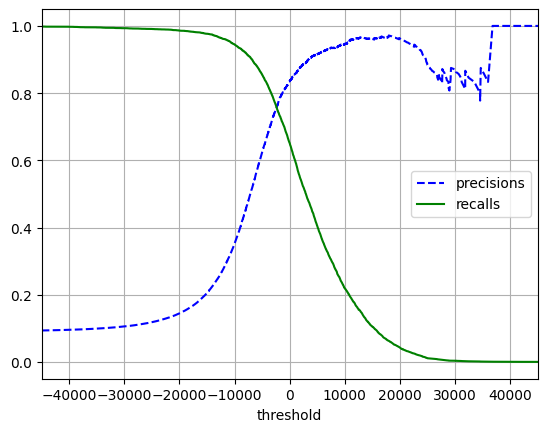

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precisions")
    plt.plot(thresholds, recalls[:-1], "g-", label="recalls")
    plt.legend()
    plt.grid(visible=True)
    plt.xlim(-45000, 45000)
    plt.xlabel('threshold')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

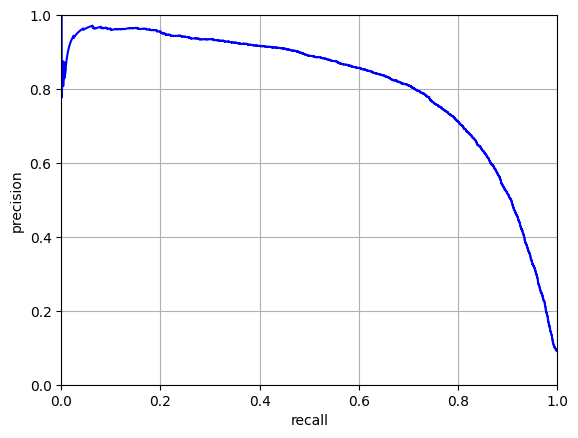

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.grid(visible=True)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('recall')
    plt.ylabel('precision')

plot_precision_vs_recall(precisions, recalls)
plt.show()

재현율/정밀도 그래프의 기울기가 재현율 80%지점에서 급격히 떨어지기 시작한다.    
기울기가 떨어지기 직전이 재현율 60% 지점의 임계값을 선택하는 것이 좋다

In [32]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #3370~
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [33]:
ps = precision_score(y_train_5, y_train_pred_90)
rs = recall_score(y_train_5, y_train_pred_90)
ps, rs

(0.9000345901072293, 0.4799852425751706)

### ROC 곡선
receiver operating characteristic.  
거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR) 곡선  
FPR = FP/(FP+TN)  
TPR = TP/(TP+FN) -> 재현율

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

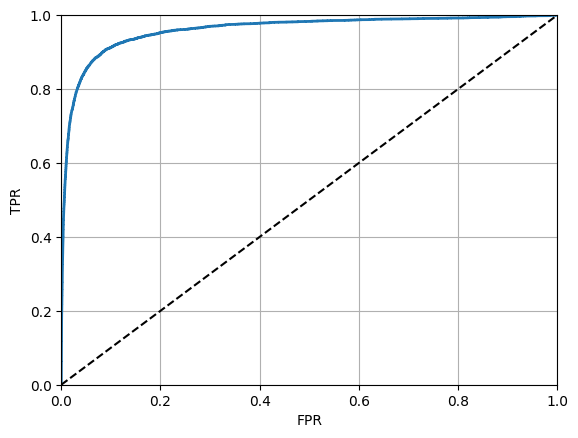

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.grid(visible=True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')

plot_roc_curve(fpr, tpr)
plt.show()

재현율이 높을수록 FPR 증가! (tradeoff!!!)  
좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야 한다.   
완벽한 분류기 -> AUC = 1  
완전한 랜덤 분류기 -> AUC = 0.5

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba", n_jobs=-1)

In [39]:
y_scores_forest = y_probas_forest[:, 1] #양성 클래스일 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

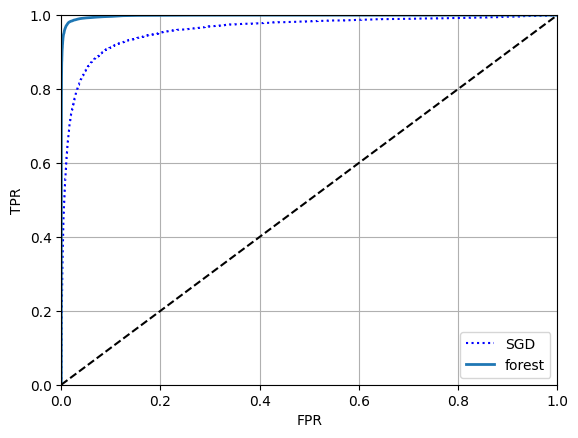

In [40]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="forest")
plt.legend()
plt.show()

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 다중 분류

SGD 분류기, random forest 분류기, naive Bayes 분류기:여러개의 클래스 직접 처리 가능.  
로지스틱 회귀, SVM: 이진 분류만 가능.  
이진 분류기를 여러 개 사용해 다중 분류 가능.  
- OvR(OvA): 각 숫자별로 이진 분류기를 하나씩 훈련시켜 가장 결정 점수가 높은 것 선택
- OvO: 0과 1, 1과 2 처럼 각 숫자의 조합마다 이진 분류기를 훈련시켜 가장 많이 양성으로 분류된 클래스 선택

In [42]:
#이진 분류 알고리즘을 다중 클래스 분류 작업에 사용하면 자동으로 OvO 또는 OvR을 선택
from sklearn.svm import SVC

svm_clf = SVC()

In [43]:
svm_clf.fit(X_train, y_train) #다중 분류이기 떄문에 y_train_5 말고 y_train 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [45]:
np.argmax(some_digit_scores)

5

In [46]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [47]:
#OneVsOneClassifier, OneVsRestClassifier 를 통해서 OvO, OvR 설정 가능

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(), n_jobs=-1)

In [49]:
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [50]:
len(ovr_clf.estimators_)

10

In [51]:
#sgd 분류기는 바로 다중 분류가 가능
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [52]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy",n_jobs=-1)

array([0.87365, 0.85835, 0.8689 ])

표준화 스케일링으로 정확도 올리기

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [57]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.8983, 0.891 , 0.9018])

# 에러 분석

### 오차행렬 이용

In [59]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [60]:
#대각선이 올바르게 분류된 이미지들
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

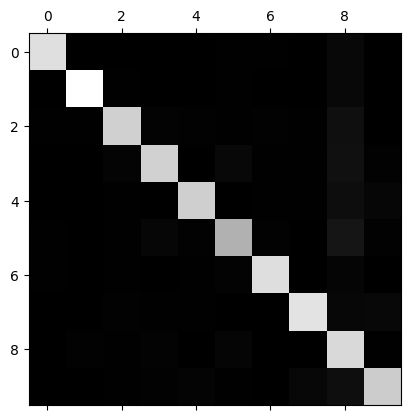

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

숫자 5는 다른 숫자보다 좀 더 어둡다.   
1. 숫자 5의 이미지가 적거나
2. 숫자 5를 잘 분류하지 못함

In [65]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

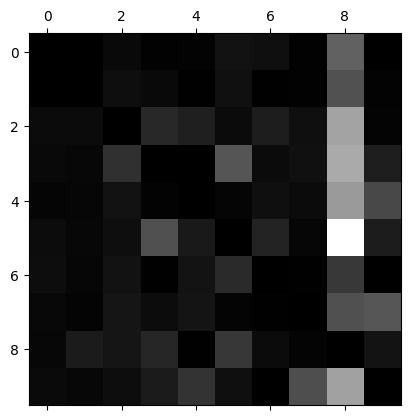

In [66]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

col 8이 매우 밝음 > 8로 잘못 분류된 이미지가 많다
(3,5), (5,3)도 밝음 > 3과 5 사이에서 잘못 분류된 이미지가 많다

In [69]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [73]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
 
    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

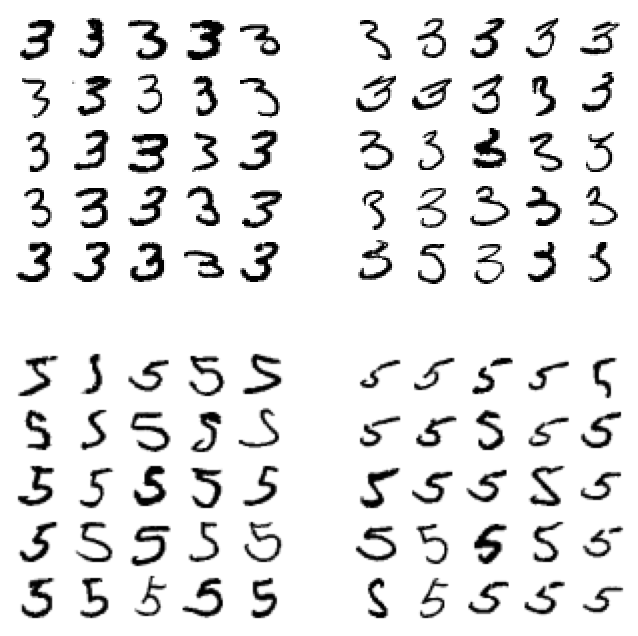

In [74]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 다중 레이블 분류
여러개의 이진 클래스에 할당

In [75]:
from sklearn.neighbors import KNeighborsClassifier

In [77]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [78]:
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(n_jobs=-1)

In [79]:
knn_clf.predict([some_digit])
#5는 7보다 작으면서 홀수

array([[False,  True]])

In [81]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro") #모든 레이블의 가중치가 같음

0.976410265560605

# 다중 출력 분류
여러개의 다중 클래스에 할당

In [97]:
#MNIST 데이터셋에 noise 넣은 후 깨끗한 이미지로 분류하기
#각각의 픽셀이 레이블, 모두 0~255까지의 값 가질 수 있음

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [98]:
some_index = np.random.randint(0, len(X_test))
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

In [99]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

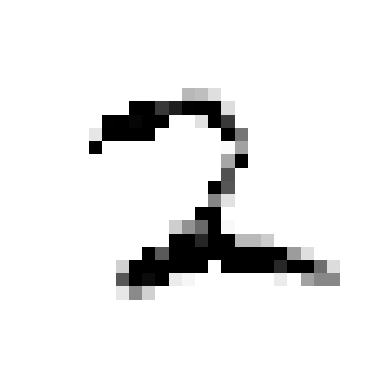

In [100]:
plot_digit(clean_digit)

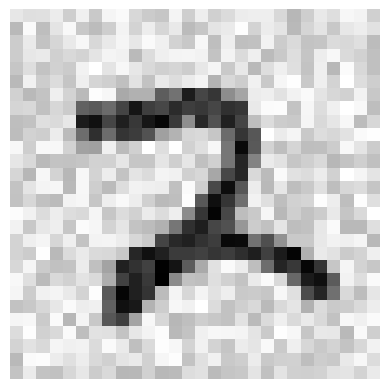

In [101]:
plot_digit(X_test_mod[some_index])

# 연습문제

1번

In [102]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [105]:
y_test_knn_pred = knn_clf.predict(X_test)

In [110]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_knn_pred)

0.9688

In [108]:
cross_val_score(knn_clf, X_train, y_train, cv=3, n_jobs=-1)

array([0.9676 , 0.9671 , 0.96755])

In [111]:
from sklearn.model_selection import GridSearchCV

In [113]:
param_grid = [
    {'n_neighbors': [3, 5, 8]},
    {'weights': ['distance'], 'n_neighbors': [3, 5, 8]}
]

grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [114]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 5, 8]},
                         {'n_neighbors': [3, 5, 8], 'weights': ['distance']}],
             scoring='accuracy')

In [117]:
grid_search.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [118]:
knn_clf_best = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=3)
knn_clf_best.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='distance')

In [120]:
y_test_best_knn_pred = knn_clf_best.predict(X_test)
accuracy_score(y_test, y_test_best_knn_pred)

0.9717

2번

In [145]:
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    return shift(image, [dy, dx]).reshape([-1])

In [154]:
X_train_augumented = []
y_train_augumented = []

for dx, dy in [(1, 0), (0, 1), (-1, 0), (0, -1)]:
    for image, label in zip(X_train, y_train):
        X_train_augumented.append(shift_image(image, dx, dy))
        y_train_augumented.append(label)

X_train_augumented = np.vstack((X_train, X_train_augumented))
y_train_augumented = np.append(y_train, y_train_augumented)

In [163]:
shuffle_idx = np.random.permutation(len(X_train_augumented))
X_train_augumented = X_train_augumented[shuffle_idx]
y_train_augumented = y_train_augumented[shuffle_idx]

In [164]:
knn_clf_best.fit(X_train_augumented, y_train_augumented)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='distance')

In [165]:
y_test_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.9688